<a href="https://colab.research.google.com/github/FXtest2023/FXtest2023/blob/main/lightGBM_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas_ta
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=b583dca21d51ac72c71da5c3e5849ad9aca0ab4b2fe4a8922e1c6e7bac9fd3a7
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.5 MB/s eta 0:00:00


In [2]:

from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as pd_ta
from sklearn.model_selection import KFold
from optuna.integration import lightgbm as lgb
#import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold

In [3]:
url = "https://raw.githubusercontent.com/FXtest2023/FXtest2023/5167452d53ac943d8cdb8218a7604a8b530bf465/USDJPY_1H.csv"
df_1H = pd.read_csv(url)

In [4]:
df_1H

,utc_datetime,bid_open,bid_high,bid_low,bid_close
0,2015-01-01 23:00:00+00:00,119.748,119.819,119.737,119.810
1,2015-01-02 00:00:00+00:00,119.809,119.946,119.791,119.866
2,2015-01-02 01:00:00+00:00,119.874,120.048,119.831,120.048
3,2015-01-02 02:00:00+00:00,120.055,120.382,120.039,120.273
4,2015-01-02 03:00:00+00:00,120.266,120.400,120.261,120.325
...,...,...,...,...,...
52567,2023-07-06 21:00:00+00:00,144.081,144.112,144.040,144.044
52568,2023-07-06 22:00:00+00:00,144.023,144.056,143.975,144.005
52569,2023-07-06 23:00:00+00:00,144.014,144.049,144.014,144.040
52570,2023-07-07 00:00:00+00:00,144.045,144.045,143.881,143.933


In [5]:
def calc_features(df):
    open = df['bid_open']
    high = df['bid_high']
    low = df['bid_low']
    close = df['bid_close']
 #   volume = df['volume']

    orig_columns = df.columns

    hilo = (df['bid_high'] + df['bid_low']) / 2
    # 価格(hilo または close)を引いた後、価格(close)で割ることで標準化

    bbands_df = pd_ta.bbands(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] = (bbands_df.iloc[:, 2] - hilo) / close
    df['BBANDS_middleband'] = (bbands_df.iloc[:, 1] - hilo) / close
    df['BBANDS_lowerband'] = (bbands_df.iloc[:, 0] - hilo) / close
    df['DEMA'] = (pd_ta.dema(close, timeperiod=30) - hilo) / close
    df['EMA'] = (pd_ta.ema(close, timeperiod=30) - hilo) / close

#    https://github.com/twopirllc/pandas-ta/issues/411
#    df['HT_TRENDLINE'] = (pd_ta.HT_TRENDLINE(close) - hilo) / close
    df['KAMA'] = (pd_ta.kama(close, timeperiod=30) - hilo) / close
    df['MIDPOINT'] = (pd_ta.midpoint(close, timeperiod=14) - hilo) / close
    df['SMA'] = (pd_ta.sma(close, timeperiod=30) - hilo) / close
    df['T3'] = (pd_ta.t3(close, timeperiod=5, vfactor=0) - hilo) / close
    df['TEMA'] = (pd_ta.tema(close, timeperiod=30) - hilo) / close
    df['TRIMA'] = (pd_ta.trima(close, timeperiod=30) - hilo) / close
    df['WMA'] = (pd_ta.wma(close, timeperiod=30) - hilo) / close
#    df['LINEARREG'] = (pd_ta.LINEARREG(close, timeperiod=14) - close) / close
#    df['LINEARREG_INTERCEPT'] = (pd_ta.LINEARREG_INTERCEPT(close, timeperiod=14) - close) / close


    # 価格(close)で割ることで標準化
#    df['AD'] = pd_ta.AD(high, low, close, volume) / close
#    df['ADOSC'] = pd_ta.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10) / close
    df['APO'] = pd_ta.apo(close, fastperiod=12, slowperiod=26, matype=0) / close
#    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = pd_ta.HT_PHASOR(close)
#    df['HT_PHASOR_inphase'] /= close
#    df['HT_PHASOR_quadrature'] /= close
    df['LINEARREG_SLOPE'] = pd_ta.slope(close, timeperiod=14) / close
    macd = pd_ta.macd(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD_macd'] = macd.iloc[:, 0] / close
    df['MACD_macdsignal'] =  macd.iloc[:, 1] / close
    df['MACD_macdhist'] =  macd.iloc[:, 2] / close
#    df['MINUS_DM'] = pd_ta.MINUS_DM(high, low, timeperiod=14) / close
    df['MOM'] = pd_ta.mom(close, timeperiod=10) / close
#    df['OBV'] = pd_ta.OBV(close, volume) / close
#    df['PLUS_DM'] = pd_ta.PLUS_DM(high, low, timeperiod=14) / close
    df['STDEV'] = pd_ta.stdev(close, timeperiod=5, nbdev=1) / close
#    df['TRANGE'] = pd_ta.TRANGE(high, low, close) / close


    df['ADX'] = pd_ta.adx(high, low, close, timeperiod=14).iloc[:, 0] / 100
#    df['ADXR'] = pd_ta.ADXR(high, low, close, timeperiod=14)
    aroon = pd_ta.aroon(high, low, timeperiod=14)
    df['AROON_aroondown'] = aroon.iloc[:, 0] / 100
    df['AROON_aroonup'] = aroon.iloc[:, 1] / 100
#    df['AROONOSC'] = pd_ta.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = pd_ta.bop(open, high, low, close)
    df['CCI'] = pd_ta.cci(high, low, close, timeperiod=14) / 100
#    df['DX'] = pd_ta.DX(high, low, close, timeperiod=14)
    # skip MACDEXT MACDFIX たぶん同じなので
#    df['MFI'] = pd_ta.MFI(high, low, close, volume, timeperiod=14)
#    df['MINUS_DI'] = pd_ta.MINUS_DI(high, low, close, timeperiod=14)
#    df['PLUS_DI'] = pd_ta.PLUS_DI(high, low, close, timeperiod=14)
    df['RSI'] = pd_ta.rsi(close, timeperiod=14) / 100

    stoch = pd_ta.stoch(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCH_slowk'] = stoch.iloc[:, 0] / 100
    df['STOCH_slowd'] = stoch.iloc[:, 1] / 100

#    df['STOCHF_fastk'], df['STOCHF_fastd'] = pd_ta.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    stochrsi = pd_ta.stochrsi(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)

    df['STOCHRSI_fastk'] = stochrsi.iloc[:, 0] / 100
    df['STOCHRSI_fastd'] = stochrsi.iloc[:, 1] / 100

    df['TRIX'] = pd_ta.trix(close, timeperiod=30).iloc[:, 1]
#    df['ULTOSC'] = pd_ta.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = pd_ta.willr(high, low, close, timeperiod=14) / 100

    df['ATR'] = pd_ta.atr(high, low, close, timeperiod=14)
    df['NATR'] = pd_ta.natr(high, low, close, timeperiod=14)

#    df['HT_DCPERIOD'] = pd_ta.HT_DCPERIOD(close)
#    df['HT_DCPHASE'] = pd_ta.HT_DCPHASE(close)
#    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = pd_ta.HT_SINE(close)
#    df['HT_TRENDMODE'] = pd_ta.HT_TRENDMODE(close)

#    df['BETA'] = pd_ta.BETA(high, low, timeperiod=5)
#    df['CORREL'] = pd_ta.cti(high, low, timeperiod=30)

#    df['LINEARREG_ANGLE'] = pd_ta.LINEARREG_ANGLE(close, timeperiod=14)
    return df

df = calc_features(df_1H)
df.dropna(inplace=True)
# df.to_csv('output.csv', index=False, encoding = 'utf-8-sig')
# files.download('output.csv')



In [6]:
df['diff']  = df['bid_close'].shift(-1) - df['bid_close']
df['label'] = df['diff'].apply(lambda x: 1 if x>0 else 0 )
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df

,utc_datetime,bid_open,bid_high,bid_low,bid_close,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,STOCH_slowk,STOCH_slowd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,WILLR,ATR,NATR,diff,label
0,2015-01-05 13:00:00+00:00,120.257,120.257,120.040,120.118,0.002313,0.000843,-0.000626,0.000675,0.001203,...,0.375531,0.424923,0.164391,0.165157,0.000116,-0.809683,0.188649,0.159261,-0.312,0
1,2015-01-05 14:00:00+00:00,120.142,120.156,119.758,119.806,0.004584,0.001536,-0.001512,0.001027,0.002066,...,0.209280,0.334552,0.042169,0.123650,0.000096,-0.943195,0.204482,0.182680,-0.300,0
2,2015-01-05 15:00:00+00:00,119.810,119.814,119.497,119.506,0.008033,0.002901,-0.002230,0.001810,0.003531,...,0.085086,0.223299,0.000000,0.068853,0.000034,-0.991863,0.212957,0.194088,0.118,1
3,2015-01-05 16:00:00+00:00,119.471,119.644,119.406,119.624,0.007470,0.002785,-0.001900,0.001958,0.003929,...,0.082355,0.125574,0.052231,0.031467,-0.000080,-0.817878,0.214835,0.194571,0.015,1
4,2015-01-05 17:00:00+00:00,119.581,119.744,119.443,119.639,0.004764,0.001213,-0.002338,0.000760,0.002815,...,0.128304,0.098582,0.111039,0.054423,-0.000254,-0.805347,0.221277,0.202152,-0.078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52528,2023-07-06 20:00:00+00:00,144.124,144.137,144.061,144.085,0.000512,0.000028,-0.000457,-0.000010,-0.000032,...,0.531073,0.526051,0.828761,0.836126,-0.004319,-0.502825,0.214143,0.149312,-0.041,0
52529,2023-07-06 21:00:00+00:00,144.081,144.112,144.040,144.044,0.000719,0.000149,-0.000422,0.000030,0.000064,...,0.492153,0.517577,0.751853,0.809364,-0.004510,-0.541431,0.203990,0.136105,-0.039,0
52530,2023-07-06 22:00:00+00:00,144.023,144.056,143.975,144.005,0.001239,0.000465,-0.000310,0.000272,0.000383,...,0.448063,0.490430,0.675739,0.752118,-0.004671,-0.611554,0.195205,0.125490,0.035,1
52531,2023-07-06 23:00:00+00:00,144.014,144.049,144.014,144.040,0.000686,0.000176,-0.000335,0.000111,0.000233,...,0.423441,0.454552,0.655306,0.694299,-0.004809,-0.576693,0.184405,0.112804,-0.107,0


In [7]:
len(df[df['label']==1])

26652

In [8]:
len(df[df['label']==0])

25881

In [9]:
df_train = df[ : 40000]
df_test  = df[40000 : ]


In [10]:
drop_cols = ['utc_datetime','bid_open',	'bid_high',	'bid_low','bid_close', 'diff','label']
X_train=df_train.drop(columns=drop_cols).values
Y_train=df_train['label'].values
Y_train = Y_train.reshape(-1)

X_test=df_test.drop(columns=drop_cols).values
Y_test=df_test['label'].values
Y_test = Y_test.reshape(-1)

In [11]:
# 乱数シードの固定
SEED = 123

# LightGBM訓練用関数を定義
def trainGbdt(X_train, y_train):
    bests = []
    kf = KFold(n_splits=5, shuffle=False)
    for learn_index, valid_index in kf.split(X_train, y_train):
        X_learn, X_valid = X_train[learn_index], X_train[valid_index]
        y_learn, y_valid = y_train[learn_index], y_train[valid_index]

        #LGB用のデータに変形
        lgb_learn = lgb.Dataset(X_learn, y_learn)
        lgb_valid = lgb.Dataset(X_valid, y_valid)

        param = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'random_seed':SEED,
            'verbose':-1,
#            'device': 'gpu',
 #           'force_col_wise': True,
        }

        # 訓練実施
        best = lgb.train(param,
                         lgb_learn,
                         valid_sets=[lgb_learn,lgb_valid],
                         verbose_eval=False
                        )
        bests.append(best)

    return bests

In [12]:
bests_ = trainGbdt(X_train, Y_train)

[I 2023-07-12 12:30:35,400] A new study created in memory with name: no-name-1af649fe-3280-4658-8dd2-de00b5fc33da
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.523585: 100%|##########| 5/5 [02:40<00:00, 32.12s/it]
[I 2023-07-12 13:00:40,261] A new study created in memory with name: no-name-cc75020e-3e36-458e-9149-59752c498394
min_data_in_leaf, val_score: 0.517973: 100%|##########| 5/5 [04:50<00:00, 58.04s/it]
[I 2023-07-12 13:50:20,379] A new study created in memory with name: no-name-302a396a-caf1-4973-93c5-bb6f01543a8a
min_data_in_leaf, val_score: 0.523460: 100%|##########| 5/5 [01:03<00:00

In [13]:
i = 0
result = []
kf = KFold(n_splits=5, shuffle=False)
for learn_index, valid_index in kf.split(X_train, Y_train):
  X_learn, X_valid = X_train[learn_index], X_train[valid_index]
  y_learn, y_valid = Y_train[learn_index], Y_train[valid_index]
  y_pred_learn = bests_[i].predict(X_learn, num_iteration=bests_[i].best_iteration)
  y_pred_valid = bests_[i].predict(X_valid, num_iteration=bests_[i].best_iteration)
  result.append([accuracy_score(y_learn, np.round(y_pred_learn)), accuracy_score(y_valid, np.round(y_pred_valid))])
  i=i+1
print(result)

[[1.0, 0.515], [1.0, 0.51575], [0.99840625, 0.521625], [1.0, 0.524125], [1.0, 0.50975]]


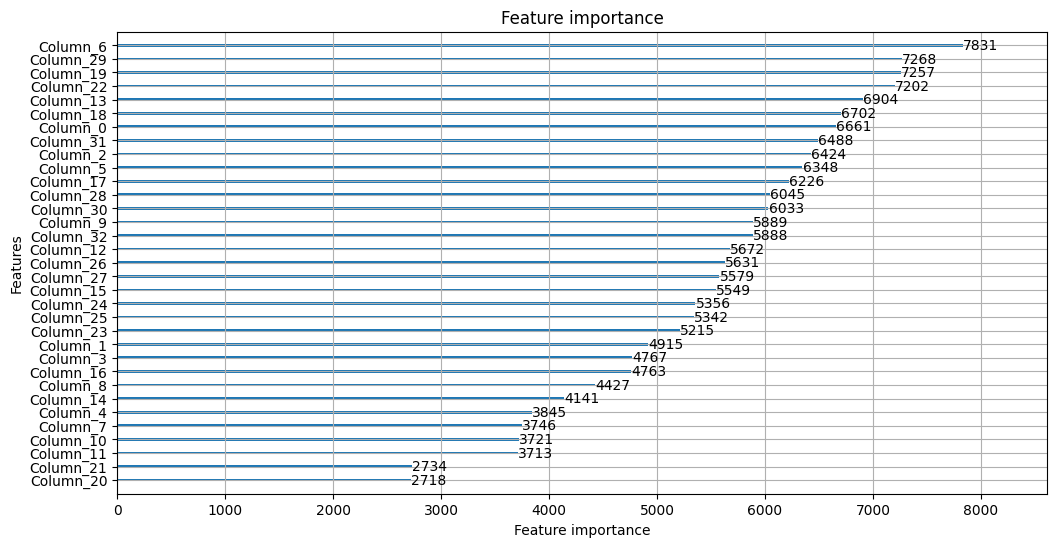

In [14]:
lgb.plot_importance(bests_[0], figsize=(12, 6))
plt.show()

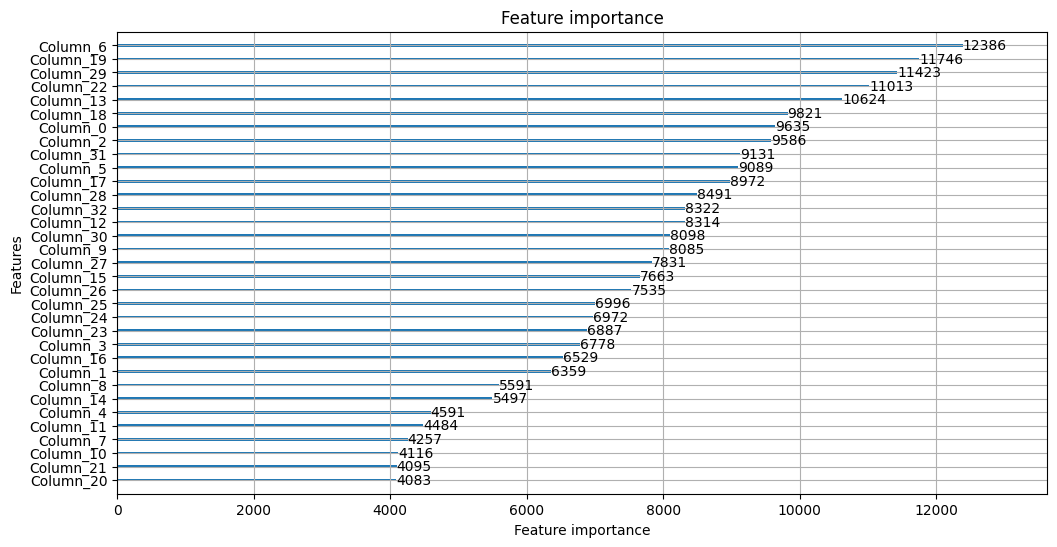

In [15]:
lgb.plot_importance(bests_[1], figsize=(12, 6))
plt.show()

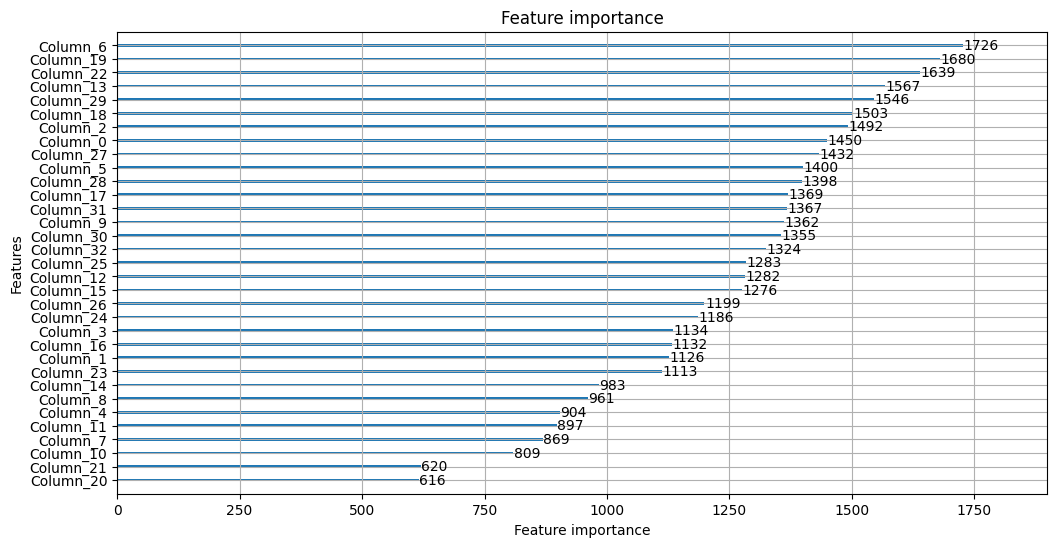

In [16]:
lgb.plot_importance(bests_[2], figsize=(12, 6))
plt.show()

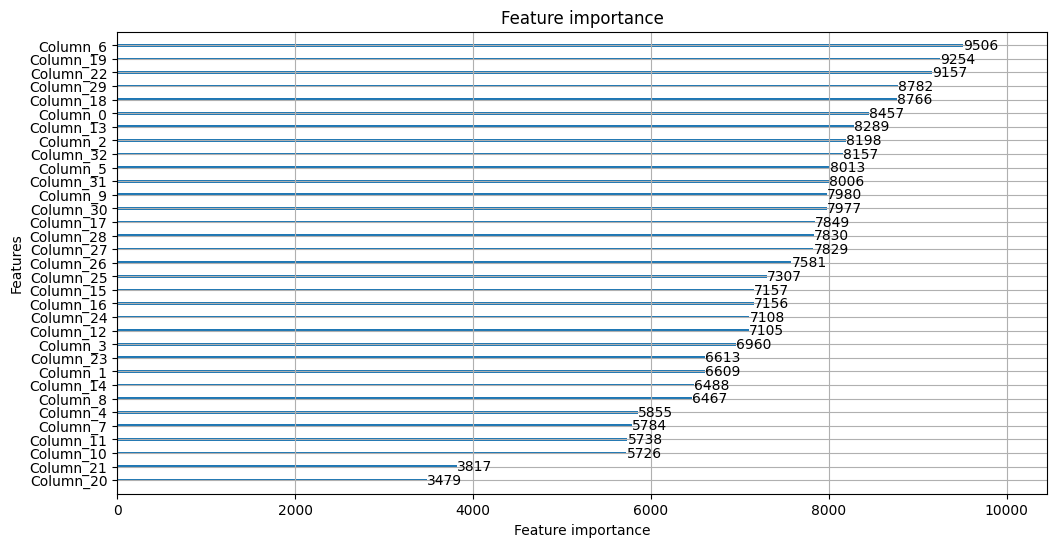

In [17]:
lgb.plot_importance(bests_[3], figsize=(12, 6))
plt.show()

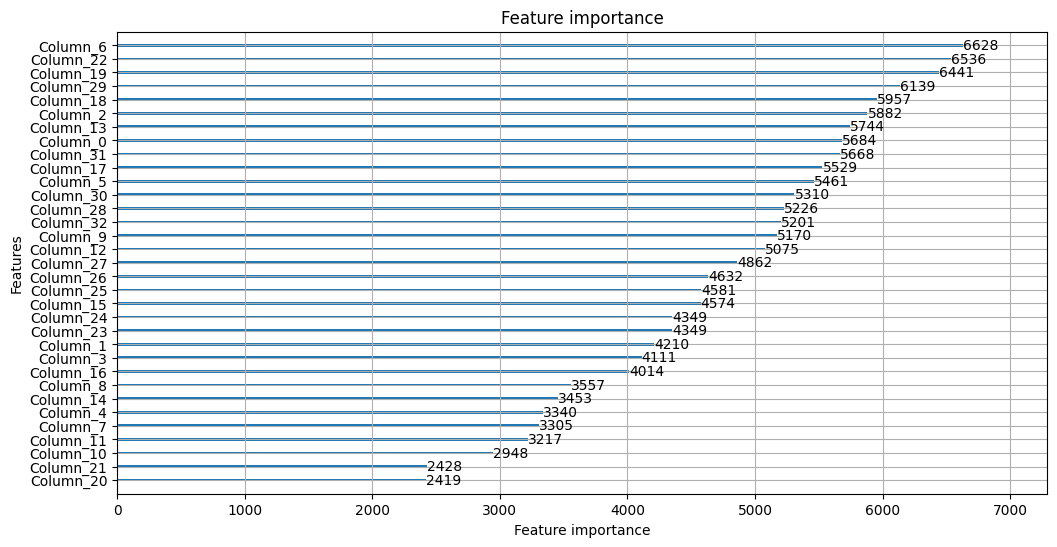

In [18]:
lgb.plot_importance(bests_[4], figsize=(12, 6))
plt.show()

In [19]:
y_preds = []
for i in range(5):
    y_pred = bests_[i].predict(X_train, num_iteration=bests_[i].best_iteration)
    y_preds.append(y_pred)
y_pred = (y_preds[0] + y_preds[1]+ y_preds[2]+ y_preds[3]+ y_preds[4])/5

accuracy_score(Y_train, np.round(y_pred))

1.0

In [20]:
y_preds = []
for i in range(5):
    y_pred = bests_[i].predict(X_test, num_iteration=bests_[i].best_iteration)
    y_preds.append(y_pred)
y_pred = (y_preds[0] + y_preds[1]+ y_preds[2]+ y_preds[3]+ y_preds[4])/5
accuracy_score(Y_test, np.round(y_pred))

0.5058645176733424

<Axes: >

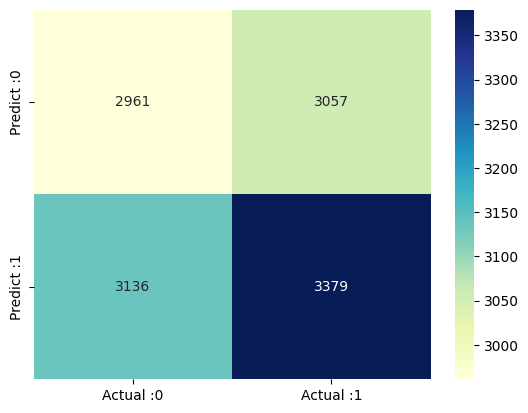

In [21]:
cm = confusion_matrix(np.round(y_pred), Y_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual :0', 'Actual :1'],
                                 index=['Predict :0', 'Predict :1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')